In [1]:
# Base & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

# Oversampling
from imblearn.combine import  SMOTETomek

# Modeling
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression

# Scoring
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report

# BayesianOptimizer
from bayes_opt import BayesianOptimization

# Saving Model
import joblib

ModuleNotFoundError: No module named 'sklearn.exceptions'

# Data Generate

In [2]:
# Data Load
train = pd.read_csv('data/part/one-hot_encoding/iterative/part_one_iter_train.csv')
label = pd.read_csv('data/raw_label.csv')
test = pd.read_csv('data/one_hot_test.csv')
test_id = pd.read_csv('data/sample_submission.csv')['ID']

train_x = np.array(train)
train_y = np.array(label)
test_x = np.array(test)

In [3]:
train

,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CD,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,1486.0,7.0,200.0,0.0,3.0,93.0,0.0,0.0,3059.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1350.0,51.0,375.0,0.0,2.0,19.0,0.0,0.0,2978.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2415.0,2.0,200.0,0.0,110.0,1.0,1.0,0.0,17.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7389.0,2.0,200.0,0.0,8.0,3.0,0.0,0.0,1960.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3954.0,4.0,200.0,0.0,1.0,157.0,0.0,0.0,71.0,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616.0,8.0,200.0,0.0,2.0,201.0,1.0,0.0,6.0,0.000000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14091,2784.0,2.0,200.0,0.0,3.0,85.0,0.0,0.0,2945.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14092,1788.0,9.0,550.0,0.0,6.0,0.0,1.0,0.0,13.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14093,2498.0,19.0,550.0,0.0,2.0,4.0,0.0,0.0,2244.0,0.009094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# Data split
x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.3, random_state = 17, stratify = train_y)

In [4]:
# Oversampling - train
tomek = SMOTETomek(random_state = 17, n_jobs = -1)
tomek_x_train, tomek_y_train = tomek.fit_sample(x_train, y_train)
print(tomek_x_train.shape, tomek_y_train.shape)

(17868, 53) (17868,)


In [5]:
# Making tomek_s_train & x_s_val for Task2
tomek_s_train = np.array(pd.DataFrame(tomek_x_train, columns = train.columns).loc[:,test.columns])
x_s_val = np.array(pd.DataFrame(x_val, columns = train.columns).loc[:,test.columns])

# Generate Hyperparameters by Model

In [41]:
# Catboost
cb_pbounds = { 'n_estimators' : (200, 500),
               'learning_rate' : (0.01, 0.5),
               'max_depth' : (4, 10),
               'random_strength' : (0, 0.9),
               'l2_leaf_reg' : (1, 5) }

# XGB
xgb_pbounds = { 'n_estimators' : (50, 500),
                'learning_rate' : (0.001, 0.5),
                'max_depth' : (4, 10),
                'subsample' : (0.7, 1),
                'colsample_bytree' : (0.7, 1),
                'reg_alpha' : (0.01, 10),
                'reg_lambda' : (0.01, 10),
                'gamma' : (0.01, 10),
                'min_child_weight' : (1, 15) }

# LGBM
lgbm_pbounds = { 'n_estimators' : (100, 400),
                 'learning_rate' : (0.01, 0.5),
                 'max_depth' : (4, 10),
                 'min_child_samples' : (5,50),
                 'subsample' : (0.7, 1),
                 'colsample_bytree' : (0.7, 0.95),
                 'reg_alpha' : (0.01, 10),
                 'reg_lambda' : (0.01, 10),
                 'min_child_weight' : (1, 15),
                 'min_split_gain' : (10,100) }

# ExtraTree
et_pbounds = { 'n_estimators' : (50, 300), 'max_depth' : (4, 10),
               'min_samples_split' : (2, 15), 'min_samples_leaf' : (2, 15) }

# Logistic
lr_pbounds = { 'max_iter' : (50, 500), 'C' : (0.01, 1) }

# Task1 : Making a Label predict_proba at y_train

### Generate Functoin for Bayesian Optimizer (Classifier)

In [12]:
def cb_clf_opt(n_estimators, learning_rate, max_depth, random_strength, l2_leaf_reg):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'random_strength' : random_strength,
               'l2_leaf_reg' : l2_leaf_reg }
    
    cb = CatBoostClassifier(**params)
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(cb, tomek_x_train, tomek_y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def xgb_clf_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, reg_alpha, reg_lambda, gamma, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'reg_alpha' : reg_alpha,
               'reg_lambda' : reg_lambda,
               'gamma' : gamma,
               'min_child_weight' : min_child_weight, 'n_jobs' : -1 }
    
    xgb = XGBClassifier(**params)
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(xgb, tomek_x_train, tomek_y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lgbm_clf_opt(n_estimators, learning_rate, max_depth, min_child_samples, subsample, colsample_bytree, 
                 reg_alpha, reg_lambda, min_child_weight, min_split_gain):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'min_child_samples' : int(round(min_child_samples)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'reg_alpha' : reg_alpha,
               'reg_lambda' : reg_lambda,
               'min_child_weight' : min_child_weight,
               'min_split_gain' : min_split_gain, 'n_jobs' : -1 }
    
    lgbm = LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(lgbm, tomek_x_train, tomek_y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def et_clf_opt(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'max_depth' : int(round(max_depth)),
               'min_samples_split' : int(round(min_samples_split)),
               'min_samples_leaf' : int(round(min_samples_leaf)), 'n_jobs' : -1 }
    
    et = ExtraTreesClassifier(**params)
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(et, tomek_x_train, tomek_y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lr_clf_opt(max_iter, C):
    
    params = { 'max_iter' : int(round(max_iter)), 'C' : C, 'n_jobs' : -1 }
    
    lr = LogisticRegression(**params)
    skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(lr, tomek_x_train, tomek_y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return np.mean(score)

### Generate BayesianOptimization

In [15]:
BO_cb_clf = BayesianOptimization(f = cb_clf_opt, pbounds = cb_pbounds, random_state=17)
BO_xgb_clf = BayesianOptimization(f = xgb_clf_opt, pbounds = xgb_pbounds, random_state=17)
BO_lgbm_clf = BayesianOptimization(f = lgbm_clf_opt, pbounds = lgbm_pbounds, random_state=17)
BO_et_clf = BayesianOptimization(f = et_clf_opt, pbounds = et_pbounds, random_state=17)
BO_lr_clf = BayesianOptimization(f = lr_clf_opt, pbounds = lr_pbounds, random_state=17)

### Optimizer Maximize

In [ ]:
# Catboost Maximize
BO_cb_clf.maximize(init_points=50, n_iter=150, acq = 'poi')

In [ ]:
# XGB Maximize
BO_xgb_clf.maximize(init_points=50, n_iter=150, acq = 'poi')

In [9]:
# LGBM Maximize
BO_lgbm_clf.maximize(init_points=50, n_iter=150, acq = 'poi')

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.9383    | 0.7884    | 0.2658    | 4.341     | 8.056     | 12.02     | 69.07     | 336.9     | 5.76      | 0.4002    | 0.8073    |
| 2         | 0.9372    | 0.9837    | 0.03096   | 9.048     | 44.48     | 1.717     | 68.72     | 298.3     | 5.979     | 4.84      | 0.7849    |
| 3         | 0.9573    | 0.7893    | 0.2812    | 5.772     | 40.49     | 6.859     | 22.95     | 117.9     | 0.5619    | 7.183     | 0.7877    |
| 4         | 0.9576    | 0.7596    | 0.4159    | 6.976     | 8.705     | 8.63      | 24.31     | 354.5     | 1.194     | 4.456     | 0.9664    |
| 5         | 0.9363    | 0.9392    | 0.03492   | 9.726     | 34.66     | 11.06     | 76.92     | 449.5     | 1.348     | 7.

| 34        | 0.941     | 0.8213    | 0.3552    | 5.013     | 17.88     | 5.666     | 55.49     | 464.8     | 7.22      | 2.677     | 0.7112    |
| 35        | 0.9326    | 0.8327    | 0.1456    | 8.403     | 23.03     | 3.607     | 89.95     | 414.2     | 3.428     | 2.884     | 0.886     |
| 36        | 0.9434    | 0.9314    | 0.3514    | 9.154     | 31.45     | 4.954     | 64.4      | 340.0     | 0.7467    | 0.9894    | 0.8237    |
| 37        | 0.9458    | 0.8013    | 0.173     | 6.453     | 19.23     | 3.763     | 49.46     | 135.4     | 6.866     | 3.967     | 0.8097    |
| 38        | 0.9463    | 0.8786    | 0.07125   | 7.544     | 10.26     | 12.38     | 52.64     | 83.35     | 4.362     | 4.963     | 0.8278    |
| 39        | 0.9453    | 0.7302    | 0.4686    | 6.17      | 46.17     | 14.77     | 47.61     | 477.9     | 3.954     | 4.033     | 0.7285    |
| 40        | 0.9602    | 0.9467    | 0.1512    | 7.198     | 31.82     | 7.77      | 12.51     | 183.3     | 9.082     | 5.

| 68        | 0.9639    | 0.8414    | 0.1826    | 7.09      | 33.65     | 8.239     | 12.91     | 168.8     | 3.469     | 2.883     | 0.9177    |
| 69        | 0.9606    | 0.7822    | 0.4012    | 4.769     | 34.92     | 6.322     | 14.96     | 167.7     | 5.922     | 4.159     | 0.703     |
| 70        | 0.9641    | 0.8492    | 0.3281    | 5.453     | 30.16     | 8.287     | 10.01     | 166.0     | 5.592     | 0.09111   | 0.8962    |
| 71        | 0.9656    | 0.7205    | 0.06584   | 6.917     | 36.59     | 4.993     | 10.19     | 170.6     | 5.745     | 2.948     | 0.8014    |
| 72        | 0.9347    | 0.7665    | 0.001     | 9.999     | 27.55     | 13.46     | 15.76     | 243.1     | 1.75      | 9.68      | 0.9009    |
| 73        | 0.9596    | 0.9202    | 0.07292   | 5.635     | 36.61     | 6.983     | 16.4      | 169.1     | 6.091     | 1.153     | 0.9448    |
| 74        | 0.9544    | 0.9562    | 0.1374    | 8.175     | 41.14     | 5.8       | 23.26     | 324.4     | 7.937     | 9.

| 102       | 0.962     | 0.9838    | 0.1962    | 4.866     | 36.48     | 10.19     | 12.43     | 175.2     | 5.545     | 2.995     | 0.8317    |
| 103       | 0.9546    | 0.8829    | 0.0174    | 7.502     | 34.58     | 7.604     | 18.07     | 175.5     | 3.246     | 7.967     | 0.8495    |
| 104       | 0.963     | 0.9833    | 0.3904    | 9.261     | 38.67     | 6.14      | 13.04     | 170.4     | 4.575     | 3.025     | 0.8186    |
| 105       | 0.9628    | 0.8645    | 0.1616    | 7.127     | 28.31     | 11.53     | 12.21     | 165.5     | 7.607     | 0.9506    | 0.8934    |
| 106       | 0.9632    | 0.8597    | 0.1734    | 6.426     | 6.559     | 7.777     | 10.72     | 313.5     | 6.366     | 1.068     | 0.8583    |
| 107       | 0.9596    | 0.9928    | 0.5       | 9.277     | 33.33     | 8.259     | 13.63     | 172.1     | 7.687     | 2.983     | 0.9996    |
| 108       | 0.961     | 0.8313    | 0.4136    | 4.728     | 39.03     | 7.543     | 15.55     | 166.5     | 3.493     | 3.

| 136       | 0.9642    | 0.8663    | 0.3795    | 7.181     | 34.65     | 5.207     | 12.35     | 163.9     | 2.266     | 3.448     | 0.7936    |
| 137       | 0.962     | 0.8313    | 0.3995    | 3.241     | 32.71     | 5.289     | 12.05     | 168.1     | 3.083     | 2.499     | 0.8076    |
| 138       | 0.9638    | 0.8561    | 0.4082    | 9.756     | 39.26     | 6.351     | 10.26     | 171.8     | 5.517     | 1.631     | 0.9253    |
| 139       | 0.966     | 0.9063    | 0.3776    | 6.435     | 30.95     | 5.567     | 11.14     | 170.3     | 3.876     | 0.4877    | 0.9526    |
| 140       | 0.9633    | 0.9155    | 0.12      | 8.292     | 33.68     | 7.845     | 10.42     | 169.5     | 6.215     | 2.491     | 0.727     |
| 141       | 0.9595    | 0.8005    | 0.2066    | 5.017     | 35.24     | 7.461     | 16.67     | 171.8     | 6.342     | 5.239     | 0.7649    |
| 142       | 0.9642    | 0.717     | 0.4491    | 6.875     | 29.23     | 5.713     | 11.64     | 168.7     | 3.669     | 1.

| 170       | 0.9616    | 0.9211    | 0.4362    | 6.834     | 38.88     | 5.036     | 11.79     | 170.5     | 7.549     | 0.9768    | 0.923     |
| 171       | 0.9642    | 0.8758    | 0.0376    | 9.361     | 39.65     | 5.996     | 10.63     | 175.2     | 7.346     | 1.202     | 0.7946    |
| 172       | 0.9624    | 0.8975    | 0.3527    | 8.358     | 36.97     | 4.921     | 10.15     | 172.0     | 8.068     | 1.709     | 0.9535    |
| 173       | 0.9637    | 0.98      | 0.2067    | 6.101     | 37.5      | 3.666     | 12.62     | 172.9     | 3.285     | 1.11      | 0.9656    |
| 174       | 0.9611    | 0.9211    | 0.05923   | 6.066     | 29.94     | 12.24     | 16.15     | 165.8     | 2.269     | 3.977     | 0.9665    |
| 175       | 0.9667    | 0.9475    | 0.23      | 5.935     | 39.91     | 2.345     | 11.8      | 169.0     | 0.2001    | 2.027     | 0.7426    |
| 176       | 0.9632    | 0.9996    | 0.177     | 7.688     | 32.72     | 8.427     | 13.8      | 167.0     | 2.242     | 7.

In [10]:
# ExtraTrees Maximize
BO_et_clf.maximize(init_points=50, n_iter=150, acq = 'poi')

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.8286    | 5.063     | 8.428     | 3.681     | 80.56     |
| 2         | 0.8714    | 8.509     | 10.19     | 9.925     | 309.0     |
| 3         | 0.7788    | 3.273     | 6.009     | 14.24     | 77.02     |
| 4         | 0.8703    | 9.048     | 13.28     | 1.717     | 343.6     |
| 5         | 0.8494    | 6.862     | 9.365     | 7.769     | 177.3     |
| 6         | 0.8379    | 5.084     | 8.861     | 6.545     | 404.9     |
| 7         | 0.8501    | 5.929     | 3.015     | 3.113     | 74.86     |
| 8         | 0.8704    | 8.026     | 5.092     | 3.783     | 424.1     |
| 9         | 0.8607    | 6.976     | 2.153     | 8.63      | 121.5     |
| 10        | 0.8733    | 7.737     | 2.659     | 7.23      | 449.6     |
| 11        | 0.8813    | 8.581     | 1.952     | 14.45     | 346.6     |
| 12        | 0.8623    | 8.031     | 

| 67        | 0.8765    | 9.272     | 5.653     | 2.255     | 284.1     |
| 68        | 0.8692    | 9.325     | 11.63     | 4.842     | 479.3     |
| 69        | 0.8717    | 8.141     | 2.281     | 7.428     | 448.9     |
| 70        | 0.847     | 6.283     | 7.11      | 9.931     | 405.3     |
| 71        | 0.8714    | 7.586     | 5.043     | 4.478     | 424.2     |
| 72        | 0.8706    | 9.294     | 11.27     | 4.841     | 479.7     |
| 73        | 0.8671    | 8.358     | 4.513     | 3.3       | 212.4     |
| 74        | 0.8182    | 4.351     | 13.06     | 2.419     | 191.3     |
| 75        | 0.8753    | 9.134     | 6.67      | 3.332     | 284.8     |
| 76        | 0.8849    | 9.54      | 6.201     | 2.768     | 283.7     |
| 77        | 0.8681    | 8.481     | 9.199     | 9.779     | 308.8     |
| 78        | 0.8766    | 9.438     | 5.656     | 11.83     | 190.2     |
| 79        | 0.8897    | 9.699     | 1.014     | 12.09     | 395.6     |
| 80        | 0.8801    | 9.009     | 

| 135       | 0.8564    | 7.368     | 7.872     | 3.879     | 193.5     |
| 136       | 0.8773    | 8.601     | 2.219     | 13.75     | 348.0     |
| 137       | 0.8206    | 4.347     | 12.77     | 7.88      | 351.1     |
| 138       | 0.8383    | 5.195     | 12.57     | 12.22     | 440.8     |
| 139       | 0.8611    | 7.422     | 2.267     | 6.485     | 449.6     |
| 140       | 0.8813    | 9.823     | 6.472     | 11.67     | 190.3     |
| 141       | 0.8742    | 8.842     | 6.698     | 3.401     | 284.1     |
| 142       | 0.8776    | 9.271     | 6.391     | 3.192     | 283.2     |
| 143       | 0.8896    | 9.674     | 2.539     | 11.68     | 396.3     |
| 144       | 0.8387    | 4.672     | 7.99      | 5.622     | 425.8     |
| 145       | 0.8257    | 3.991     | 6.915     | 4.883     | 210.2     |
| 146       | 0.8915    | 9.862     | 2.179     | 12.16     | 396.3     |
| 147       | 0.8778    | 9.509     | 11.78     | 5.19      | 477.8     |
| 148       | 0.8754    | 9.418     | 

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 476, in fit
    trees = Parallel(
  File "E:\Anaconda\lib\site-packages\joblib\parallel.py", line 1056, in __call__
    self.retrieve()
  File "E:\Anaconda\lib\site-packages\joblib\parallel.py", line 935, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "E:\Anaconda\lib\multiprocessing\pool.py", line 771, in get
    raise self._value
  File "E:\Anaconda\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "E:\Anaconda\lib\site-packages\joblib\_parallel_backends.py", line 595, in __call__
    return self.func(*args, **kwargs)
  File "E:\Anaconda\lib\site-packages\joblib\parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "E:\Anaconda\lib\site-packages\joblib\parallel.py", line 262, in <listcomp>
    return [func(*args, **kwargs)
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\fixes.py", line 117, in __call__
    return self.function(*args, **kwargs)
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py", line 191, in _parallel_build_trees
    tree.fit(X, y, sample_weight=sample_weight, check_input=False)
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py", line 969, in fit
    super().fit(
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\tree\_classes.py", line 265, in fit
    check_scalar(
  File "C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 1480, in check_scalar
    raise ValueError(
ValueError: min_samples_split == 1, must be >= 2.


### Change Max parameters from float to int

In [18]:
## Catboost Max Parameters
#cb_clf_max_params = BO_cb_clf.max['params']
#cb_clf_max_params['n_estimators'] = int(round(cb_clf_max_params['n_estimators']))
#cb_clf_max_params['max_depth'] = int(round(cb_clf_max_params['max_depth']))

## XGB Max Parameters
#xgb_clf_max_params = BO_xgb_clf.max['params']
#xgb_clf_max_params['n_estimators'] = int(round(xgb_clf_max_params['n_estimators']))
#xgb_clf_max_params['max_depth'] = int(round(xgb_clf_max_params['max_depth']))

# LGBM Max Parameters
lgbm_clf_max_params = BO_lgbm_clf.max['params']
lgbm_clf_max_params['n_estimators'] = int(round(lgbm_clf_max_params['n_estimators']))
lgbm_clf_max_params['max_depth'] = int(round(lgbm_clf_max_params['max_depth']))
lgbm_clf_max_params['min_child_samples'] = int(round(lgbm_clf_max_params['min_child_samples']))

# ExtraTrees Max Parameters
et_clf_max_params = BO_et_clf.max['params']
et_clf_max_params['n_estimators'] = int(round(et_clf_max_params['n_estimators']))
et_clf_max_params['max_depth'] = int(round(et_clf_max_params['max_depth']))
et_clf_max_params['min_samples_split'] = int(round(et_clf_max_params['min_samples_split']))
et_clf_max_params['min_samples_leaf'] = int(round(et_clf_max_params['min_samples_leaf']))

# Logistic Max Parameters
lr_clf_max_params = BO_lr_clf.max['params']
lr_clf_max_params['max_iter'] = int(round(lr_clf_max_params['max_iter']))

### Retraing the Model with best parameters

In [20]:
#tune_cb_clf = CatBoostClassifier(**cb_clf_max_params)
#tune_cb_clf.fit(tomek_x_train,tomek_y_train)

#tune_xgb_clf = XGBClassifier(**xgb_clf_max_params)
#tune_xgb_clf.fit(tomek_x_train,tomek_y_train)

tune_lgbm_clf = LGBMClassifier(**lgbm_clf_max_params)
tune_lgbm_clf.fit(tomek_x_train,tomek_y_train)

tune_et_clf = ExtraTreesClassifier(**et_clf_max_params)
tune_et_clf.fit(tomek_x_train,tomek_y_train)

tune_lr_clf = LogisticRegression(**lr_clf_max_params)
tune_lr_clf.fit(tomek_x_train,tomek_y_train)

C:\Users\82107\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=0.5562338549485265, max_iter=319)

### Validation Check

In [21]:
# Predict x_val by Tuned Model
#tune_cb_clf_pred = tune_cb_clf.predict(x_val)
#tune_xgb_clf_pred = tune_xgb_clf.predict(x_val)
tune_lgbm_clf_pred = tune_lgbm_clf.predict(x_val)
tune_et_clf_pred = tune_et_clf.predict(x_val)
tune_lr_clf_pred = tune_lr_clf.predict(x_val)

In [22]:
# Validation Score
#tune_cb_clf_val_score = f1_score(y_val, tune_cb_clf_pred, average = 'macro')
#tune_xgb_clf_val_score = f1_score(y_val, tune_xgb_clf_pred, average = 'macro')
tune_lgbm_clf_val_score = f1_score(y_val, tune_lgbm_clf_pred, average = 'macro')
tune_et_clf_val_score = f1_score(y_val, tune_et_clf_pred, average = 'macro')
tune_lr_clf_val_score = f1_score(y_val, tune_lr_clf_pred, average = 'macro')
#print(f'Catboost F1 score:{tune_cb_clf_val_score}\nXGB F1 score:{tune_xgb_clf_val_score}\n')
print(f'LGBM F1 score:{tune_lgbm_clf_val_score}\nExtraTrees F1 score:{tune_et_clf_val_score}\nLogistic F1 score:{tune_lr_clf_val_score}')

LGBM F1 score:0.8025850548395956
ExtraTrees F1 score:0.6621445722166479
Logistic F1 score:0.7382943606335106


### Generate predict_proba

In [34]:
#tune_cb_clf_pred_proba = np.array(i[1] for i in tune_cb_clf.predict_proba(tomek_x_train))
#tune_xgb_clf_pred_proba = np.array(i[1] for i in tune_xgb_clf.predict_proba(tomek_x_train))
tune_lgbm_clf_pred_proba = np.array([i[1] for i in tune_lgbm_clf.predict_proba(tomek_x_train)])
tune_et_clf_pred_proba = np.array([i[1] for i in tune_et_clf.predict_proba(tomek_x_train)])
tune_lr_clf_pred_proba = np.array([i[1] for i in tune_lr_clf.predict_proba(tomek_x_train)])

## Saving Task1 Model

In [26]:
#joblib.dump(tune_cb_clf, 'model_save/tuning/task1_cb_clf.pkl')
#joblib.dump(tune_xgb_clf, 'model_save/tuning/task1_xgb_clf.pkl')
joblib.dump(tune_lgbm_clf, 'model_save/tuning/task1_lgbm_clf.pkl')
joblib.dump(tune_et_clf, 'model_save/tuning/task1_et_clf.pkl')
joblib.dump(tune_lr_clf, 'model_save/tuning/task1_lr_clf.pkl')

['model_save/tuning/task1_lr_clf.pkl']

# Task2 : Predict Test Label by Regressor

### Generate Functoin for Bayesian Optimizer (Regressor)

In [74]:
def cb_reg_opt(n_estimators, learning_rate, max_depth, random_strength, l2_leaf_reg):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'random_strength' : random_strength,
               'l2_leaf_reg' : l2_leaf_reg }
    
    cb = CatBoostRegressor(**params)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(cb, tomek_s_train, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def xgb_reg_opt(n_estimators, learning_rate, max_depth, subsample, colsample_bytree, 
                reg_alpha, reg_lambda, gamma, min_child_weight):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'reg_alpha' : reg_alpha,
               'reg_lambda' : reg_lambda,
               'gamma' : gamma,
               'min_child_weight' : min_child_weight, 'n_jobs' : -1 }
    
    xgb = XGBRegressor(**params)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(xgb, tomek_s_train, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lgbm_reg_opt(n_estimators, learning_rate, max_depth, min_child_samples, subsample, colsample_bytree, 
                reg_alpha, reg_lambda, min_child_weight, min_split_gain):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'learning_rate' : learning_rate,
               'max_depth' : int(round(max_depth)),
               'min_child_samples' : int(round(min_child_samples)),
               'subsample' : subsample,
               'colsample_bytree' : colsample_bytree,
               'reg_alpha' : reg_alpha,
               'reg_lambda' : reg_lambda,
               'min_child_weight' : min_child_weight,
               'min_split_gain' : min_split_gain, 'n_jobs' : -1 }
    
    lgbm = LGBMRegressor(**params)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(lgbm, tomek_s_train, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def et_reg_opt(n_estimators, max_depth, min_samples_split, min_samples_leaf):
    
    params = { 'n_estimators' : int(round(n_estimators)),
               'max_depth' : int(round(max_depth)),
               'min_samples_split' : int(round(min_samples_split)),
               'min_samples_leaf' : int(round(min_samples_leaf)), 'n_jobs' : -1 }
    
    et = ExtraTreesRegressor(**params)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(et, tomek_s_train, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

def lr_reg_opt(max_iter, C):
    
    params = { 'max_iter' : int(round(max_iter)), 'C' : C, 'n_jobs' : -1 }
    
    lr = LogisticRegression(**params)
    skf = KFold(n_splits = 5, shuffle = True, random_state = 17)
    score = cross_val_score(lr, tomek_s_train, tune_et_clf_pred_proba, scoring = 'neg_mean_squared_error', cv = skf, n_jobs = -1)
    
    return np.mean(score)

### Generate BayesianOptimization

In [ ]:
BO_cb_reg = BayesianOptimization(f = cb_reg_opt, pbounds = cb_pbounds, random_state=17)
BO_xgb_reg = BayesianOptimization(f = xgb_reg_opt, pbounds = xgb_pbounds, random_state=17)

In [75]:
BO_lgbm_reg = BayesianOptimization(f = lgbm_reg_opt, pbounds = lgbm_pbounds, random_state=17)
BO_et_reg = BayesianOptimization(f = et_reg_opt, pbounds = et_pbounds, random_state=17)

In [49]:
BO_lr_reg = BayesianOptimization(f = lr_reg_opt, pbounds = lr_pbounds, random_state=17)

### Optimizer Maximize

In [ ]:
BO_cb_reg.maximize(init_points=50, n_iter=50, acq = 'ei', xi = 0.01)

In [73]:
BO_xgb_reg.maximize(init_points=5, n_iter=5, acq = 'ei', xi = 0.01)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.05658  | 0.7884    | 5.311     | 0.09657   | 3.475     | 12.02     | 345.4     | 6.379     | 5.76      | 0.7117    |
| 2         | -0.06062  | 0.8073    | 9.457     | 0.03096   | 9.048     | 13.28     | 73.04     | 6.528     | 5.522     | 0.8793    |
| 3         | -0.0447   | 0.8451    | 2.837     | 0.1496    | 6.931     | 6.545     | 404.9     | 4.191     | 1.448     | 0.7453    |
| 4         | -0.05366  | 0.7166    | 7.183     | 0.1469    | 4.391     | 12.64     | 305.6     | 0.8326    | 5.455     | 0.7477    |
| 5         | -0.04179  | 0.903     | 1.194     | 0.2231    | 9.216     | 12.16     | 80.59     | 9.608     | 6.595     | 0.9156    |
| 6         | -0.04891  | 0.8653    | 5.444     | 0.3567    | 

In [76]:
BO_lgbm_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | colsam... | learni... | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -0.02608  | 0.7884    | 0.2658    | 4.341     | 8.056     | 12.02     | 69.07     | 336.9     | 5.76      | 0.4002    | 0.8073    |
| 2         | -0.02608  | 0.9837    | 0.03096   | 9.048     | 44.48     | 1.717     | 68.72     | 298.3     | 5.979     | 4.84      | 0.7849    |
| 3         | -0.02195  | 0.7893    | 0.2812    | 5.772     | 40.49     | 6.859     | 22.95     | 117.9     | 0.5619    | 7.183     | 0.7877    |
| 4         | -0.02159  | 0.7596    | 0.4159    | 6.976     | 8.705     | 8.63      | 24.31     | 354.5     | 1.194     | 4.456     | 0.9664    |
| 5         | -0.02608  | 0.9392    | 0.03492   | 9.726     | 34.66     | 11.06     | 76.92     | 449.5     | 1.348     | 7.

| 34        | -0.02608  | 0.8213    | 0.3552    | 5.013     | 17.88     | 5.666     | 55.49     | 464.8     | 7.22      | 2.677     | 0.7112    |
| 35        | -0.02608  | 0.8327    | 0.1456    | 8.403     | 23.03     | 3.607     | 89.95     | 414.2     | 3.428     | 2.884     | 0.886     |
| 36        | -0.02608  | 0.9314    | 0.3514    | 9.154     | 31.45     | 4.954     | 64.4      | 340.0     | 0.7467    | 0.9894    | 0.8237    |
| 37        | -0.02608  | 0.8013    | 0.173     | 6.453     | 19.23     | 3.763     | 49.46     | 135.4     | 6.866     | 3.967     | 0.8097    |
| 38        | -0.02608  | 0.8786    | 0.07125   | 7.544     | 10.26     | 12.38     | 52.64     | 83.35     | 4.362     | 4.963     | 0.8278    |
| 39        | -0.02608  | 0.7302    | 0.4686    | 6.17      | 46.17     | 14.77     | 47.61     | 477.9     | 3.954     | 4.033     | 0.7285    |
| 40        | -0.01963  | 0.9467    | 0.1512    | 7.198     | 31.82     | 7.77      | 12.51     | 183.3     | 9.082     | 5.

| 68        | -0.01826  | 0.7       | 0.5       | 10.0      | 50.0      | 15.0      | 10.0      | 292.4     | 10.0      | 0.01      | 0.7       |
| 69        | -0.01601  | 1.0       | 0.5       | 3.0       | 50.0      | 15.0      | 10.0      | 268.6     | 0.01      | 10.0      | 1.0       |
| 70        | -0.01579  | 1.0       | 0.5       | 10.0      | 5.0       | 15.0      | 10.0      | 316.3     | 0.01      | 10.0      | 0.7       |
| 71        | -0.01666  | 1.0       | 0.5       | 10.0      | 5.0       | 15.0      | 10.0      | 318.6     | 10.0      | 0.01      | 0.7       |
| 72        | -0.01742  | 1.0       | 0.1381    | 10.0      | 50.0      | 1.0       | 10.0      | 284.5     | 0.01      | 10.0      | 1.0       |
| 73        | -0.01553  | 1.0       | 0.5       | 10.0      | 50.0      | 15.0      | 10.0      | 255.0     | 0.01      | 0.01      | 0.7548    |
| 74        | -0.01601  | 1.0       | 0.5       | 3.0       | 50.0      | 15.0      | 10.0      | 229.8     | 0.01      | 10

In [77]:
BO_et_reg.maximize(init_points=50, n_iter=50)

|   iter    |  target   | max_depth | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | -0.01501  | 5.063     | 8.898     | 4.49      | 80.56     |
| 2         | -0.01108  | 8.509     | 10.53     | 10.29     | 309.0     |
| 3         | -0.01788  | 3.273     | 6.652     | 14.29     | 77.02     |
| 4         | -0.01111  | 9.048     | 13.4      | 2.666     | 343.6     |
| 5         | -0.0129   | 6.862     | 9.768     | 8.286     | 177.3     |
| 6         | -0.01498  | 5.084     | 9.3       | 7.149     | 404.9     |
| 7         | -0.01386  | 5.929     | 3.871     | 3.962     | 74.86     |
| 8         | -0.01195  | 8.026     | 5.8       | 4.584     | 424.1     |
| 9         | -0.01288  | 6.976     | 3.07      | 9.085     | 121.5     |
| 10        | -0.01191  | 7.737     | 3.54      | 7.785     | 449.6     |
| 11        | -0.011    | 8.581     | 2.884     | 14.49     | 346.6     |
| 12        | -0.01205  | 8.031     | 

| 67        | -0.01017  | 10.0      | 3.068     | 13.31     | 424.3     |
| 68        | -0.01102  | 9.364     | 7.15      | 9.328     | 341.6     |
| 69        | -0.01098  | 9.407     | 7.096     | 8.254     | 162.5     |
| 70        | -0.01618  | 3.842     | 2.0       | 12.06     | 340.7     |
| 71        | -0.0103   | 9.58      | 11.27     | 13.26     | 345.9     |
| 72        | -0.01293  | 7.448     | 13.77     | 10.8      | 341.6     |
| 73        | -0.01106  | 9.001     | 7.609     | 14.77     | 349.3     |
| 74        | -0.01022  | 9.529     | 10.18     | 14.33     | 160.4     |
| 75        | -0.01109  | 8.588     | 13.22     | 12.81     | 154.1     |
| 76        | -0.01014  | 10.0      | 4.392     | 15.0      | 156.4     |
| 77        | -0.01283  | 6.564     | 2.186     | 14.93     | 160.4     |
| 78        | -0.0102   | 9.863     | 7.504     | 12.68     | 152.4     |
| 79        | -0.01015  | 10.0      | 2.0       | 15.0      | 149.7     |
| 80        | -0.01012  | 10.0      | 

### Change Max parameters from float to int

In [78]:
## Catboost Max Parameters
#cb_reg_max_params = BO_cb_reg.max['params']
#cb_reg_max_params['n_estimators'] = int(round(cb_reg_max_params['n_estimators']))
#cb_reg_max_params['max_depth'] = int(round(cb_reg_max_params['max_depth']))

## XGB Max Parameters
#xgb_reg_max_params = BO_xgb_reg.max['params']
#xgb_reg_max_params['n_estimators'] = int(round(xgb_reg_max_params['n_estimators']))
#xgb_reg_max_params['max_depth'] = int(round(xgb_reg_max_params['max_depth']))

# LGBM Max Parameters
lgbm_reg_max_params = BO_lgbm_reg.max['params']
lgbm_reg_max_params['n_estimators'] = int(round(lgbm_reg_max_params['n_estimators']))
lgbm_reg_max_params['max_depth'] = int(round(lgbm_reg_max_params['max_depth']))
lgbm_reg_max_params['min_child_samples'] = int(round(lgbm_reg_max_params['min_child_samples']))

# ExtraTrees Max Parameters
et_reg_max_params = BO_et_reg.max['params']
et_reg_max_params['n_estimators'] = int(round(et_reg_max_params['n_estimators']))
et_reg_max_params['max_depth'] = int(round(et_reg_max_params['max_depth']))
et_reg_max_params['min_samples_split'] = int(round(et_reg_max_params['min_samples_split']))
et_reg_max_params['min_samples_leaf'] = int(round(et_reg_max_params['min_samples_leaf']))

### Retraing the Model with best parameters

In [ ]:
tune_cb_reg = CatBoostRegressor(**cb_reg_max_params)
tune_cb_reg.fit(tomek_s_train,tomek_y_train)

tune_xgb_reg = XGBRegressor(**xgb_reg_max_params)
tune_xgb_reg.fit(tomek_s_train,tomek_y_train)

In [79]:
tune_lgbm_reg = LGBMRegressor(**lgbm_reg_max_params)
tune_lgbm_reg.fit(tomek_s_train,tomek_y_train)

tune_et_reg = ExtraTreesRegressor(**et_reg_max_params)
tune_et_reg.fit(tomek_s_train,tomek_y_train)

ExtraTreesRegressor(max_depth=10, min_samples_leaf=2, min_samples_split=9,
                    n_estimators=145)

### Validation Check

In [ ]:
# Predict x_s_val by Tuned Model
tune_cb_reg_val_pred = tune_cb_reg.predict(x_s_val)
tune_xgb_reg_val_pred = tune_xgb_reg.predict(x_s_val)

In [80]:
tune_lgbm_reg_val_pred = tune_lgbm_reg.predict(x_s_val)
tune_et_reg_val_pred = tune_et_reg.predict(x_s_val)

In [ ]:
# Visualize Validation predict
cb_val_pred = pd.DataFrame({'predict':tune_cb_reg_val_pred})
xgb_val_pred = pd.DataFrame({'predict':tune_xgb_reg_val_pred})

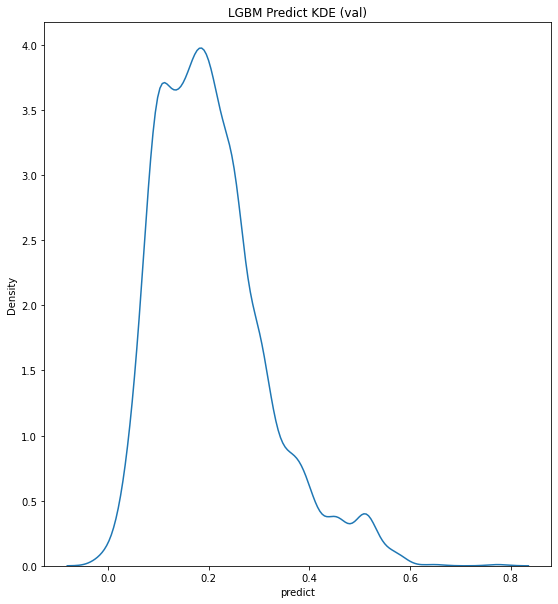

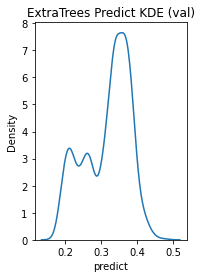

In [82]:
lgbm_val_pred = pd.DataFrame({'predict':tune_lgbm_reg_val_pred})
et_val_pred = pd.DataFrame({'predict':tune_et_reg_val_pred})
plt.figure(figsize=(20,10))

'''plt.subplot(3,2,1)
sns.kdeplot(cb_val_pred.predict)
plt.title('Caboost Predict KDE (val)')
plt.show()

plt.subplot(3,2,2)
sns.kdeplot(xgb_val_pred.predict)
plt.title('XGB Predict KDE (val)')
plt.show()'''

plt.subplot(1,2,1)
sns.kdeplot(lgbm_val_pred.predict)
plt.title('LGBM Predict KDE (val)')
plt.show()

plt.subplot(1,2,2)
sns.kdeplot(et_val_pred.predict)
plt.title('ExtraTrees Predict KDE (val)')
plt.show()

In [95]:
# Check 8.5% raw at Validation predict
print(cb_val_pred.predict.sort_values(ascending = False).iloc[358:367])
print(xgb_val_pred.predict.sort_values(ascending = False).iloc[358:367])

NameError: name 'cb_val_pred' is not defined

In [96]:
print(lgbm_val_pred.predict.sort_values(ascending = False).iloc[358:367])
print(et_val_pred.predict.sort_values(ascending = False).iloc[358:367])

1514    0.368749
657     0.368749
678     0.368749
1435    0.368749
1672    0.368749
3853    0.368749
25      0.368749
3944    0.368749
2425    0.368749
Name: predict, dtype: float64
1781    0.389136
3615    0.389113
373     0.389047
3048    0.389038
1828    0.389032
80      0.388989
443     0.388977
1408    0.388861
2262    0.388853
Name: predict, dtype: float64


In [ ]:
# predict transform by threshold
cb_trans_val_pred = np.array([0 if i < * else 1 for i in tune_cb_reg_val_pred])
xgb_trans_val_pred = np.array([0 if i < * else 1 for i in tune_xgb_reg_val_pred])

In [97]:
lgbm_trans_val_pred = np.array([0 if i < 0.368749 else 1 for i in tune_lgbm_reg_val_pred])
et_trans_val_pred = np.array([0 if i < 0.389 else 1 for i in tune_et_reg_val_pred])

In [98]:
# Validation F1-macro Score & ConfusionMatrix
'''tune_cb_reg_val_score = f1_score(y_val, cb_trans_val_pred, average = 'macro')
tune_xgb_reg_val_score = f1_score(y_val, xgb_trans_val_pred, average = 'macro')'''
tune_lgbm_reg_val_score = f1_score(y_val, lgbm_trans_val_pred, average = 'macro')
tune_et_reg_val_score = f1_score(y_val, et_trans_val_pred, average = 'macro')

'''print(f'Catboost F1 score : {tune_cb_reg_val_score}\n', classification_report(y_val, cb_trans_val_pred))
print(f'XGB F1 score : {tune_xgb_reg_val_score}\n', classification_report(y_val, xgb_trans_val_pred))'''
print(f'LGBM F1 score : {tune_lgbm_reg_val_score}\n', classification_report(y_val, lgbm_trans_val_pred))
print(f'ExtraTrees F1 score : {tune_et_reg_val_score}\n', classification_report(y_val, et_trans_val_pred))

LGBM F1 score : 0.5442241697155336
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3868
           1       0.17      0.17      0.17       361

    accuracy                           0.86      4229
   macro avg       0.54      0.54      0.54      4229
weighted avg       0.86      0.86      0.86      4229

ExtraTrees F1 score : 0.5574192022882386
               precision    recall  f1-score   support

           0       0.92      0.92      0.92      3868
           1       0.19      0.19      0.19       361

    accuracy                           0.86      4229
   macro avg       0.56      0.56      0.56      4229
weighted avg       0.86      0.86      0.86      4229



### Generate Test Predict

In [99]:
# Predict target by test_x
'''tune_cb_reg_pred = tune_cb_reg.predict(test_x)
tune_xgb_reg_pred = tune_xgb_reg.predict(test_x)'''
tune_lgbm_reg_pred = tune_lgbm_reg.predict(test_x)
tune_et_reg_pred = tune_et_reg.predict(test_x)

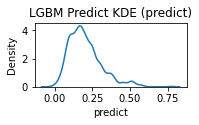

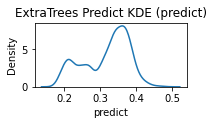

In [100]:
# Visualize target predict
'''cb_pred = pd.DataFrame({'predict':tune_cb_reg_pred})
xgb_pred = pd.DataFrame({'predict':tune_xgb_reg_pred})'''
lgbm_pred = pd.DataFrame({'predict':tune_lgbm_reg_pred})
et_pred = pd.DataFrame({'predict':tune_et_reg_pred})

'''plt.figure(figsize=(20,10))

plt.subplot(3,2,1)
sns.kdeplot(cb_pred.predict)
plt.title('Caboost Predict KDE (predict)')
plt.show()

plt.subplot(3,2,2)
sns.kdeplot(xgb_pred.predict)
plt.title('XGB Predict KDE (predict)')
plt.show()
'''
plt.subplot(3,2,3)
sns.kdeplot(lgbm_pred.predict)
plt.title('LGBM Predict KDE (predict)')
plt.show()

plt.subplot(3,2,4)
sns.kdeplot(et_pred.predict)
plt.title('ExtraTrees Predict KDE (predict)')
plt.show()

In [101]:
# target predict 8.5% raw print by Model
'''print(cb_pred.predict.sort_values(ascending = False).iloc[510:521])
print(xgb_pred.predict.sort_values(ascending = False).iloc[510:521])'''
print(lgbm_pred.predict.sort_values(ascending = False).iloc[510:521])
print(et_pred.predict.sort_values(ascending = False).iloc[510:521])

4048    0.368749
3277    0.368749
2184    0.368749
763     0.368749
3856    0.368749
626     0.368749
4595    0.368749
4178    0.368749
3828    0.366918
240     0.366918
5625    0.366918
Name: predict, dtype: float64
5663    0.388989
3731    0.388989
3857    0.388986
2727    0.388961
1782    0.388959
4008    0.388919
5797    0.388800
1725    0.388782
5140    0.388778
4722    0.388746
4759    0.388746
Name: predict, dtype: float64


In [102]:
# Transform predict by Threshold
'''cb_trans_reg_pred = np.array([0 if i < * else 1 for i in tune_cb_reg_pred])
xgb_trans_reg_pred = np.array([0 if i < * else 1 for i in tune_xgb_reg_pred])'''
lgbm_trans_reg_pred = np.array([0 if i < 0.368749 else 1 for i in tune_lgbm_reg_pred])
et_trans_reg_pred = np.array([0 if i < 0.3889 else 1 for i in tune_et_reg_pred])

## Saving Task1 Model

In [103]:
# Saving Model
'''joblib.dump(tune_cb_reg, 'model_save/tuning/task1_xxx_clf_task2_cb_reg.pkl')
joblib.dump(tune_xgb_reg, 'model_save/tuning/task1_xxx_clf_task2_xgb_reg.pkl')'''
joblib.dump(tune_lgbm_reg, 'model_save/tuning/task1_et_clf_task2_lgbm_reg.pkl')
joblib.dump(tune_et_reg, 'model_save/tuning/task1_et_clf_task2_rt_reg.pkl')

['model_save/tuning/task1_et_clf_task2_rt_reg.pkl']

## to_csv Submission

In [104]:
'''pd.DataFrame({'ID': test_id, 'Y_LABEL': cb_trans_reg_pred}).to_csv('predict/modeling/xx_clf_cb_reg_.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': xgb_trans_reg_pred}).to_csv('predict/modeling/xx_clf_xgb_reg_.csv', index=False)'''
pd.DataFrame({'ID': test_id, 'Y_LABEL': lgbm_trans_reg_pred}).to_csv('predict/modeling/et_clf_lgbm_reg_368749.csv', index=False)
pd.DataFrame({'ID': test_id, 'Y_LABEL': et_trans_reg_pred}).to_csv('predict/modeling/et_clf_et_reg_3889.csv', index=False)